In [38]:
import json
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision import transforms

from tqdm import tqdm

In [39]:
input_json_pose_mirrored_file = '../data/filtered_pose_mirrored.json'
input_pose_mirrored_folder = '../data/wiki_crop_filtered_mirrored_pose'

output_pose_cut_folder = '../data/wiki_crop_cut_pose'

In [40]:
with open(input_json_pose_mirrored_file, 'r') as f:
    records = json.load(f)

In [41]:
def make_deeplab(device):
    deeplab = deeplabv3_resnet101(pretrained=True).to(device)
    deeplab.eval()
    return deeplab

In [42]:
device = torch.device("cpu")
deeplab = make_deeplab(device)

In [43]:
sample_file = list(records.keys())[0]
sample_file

'10049200_1891-09-16_1958.jpg'

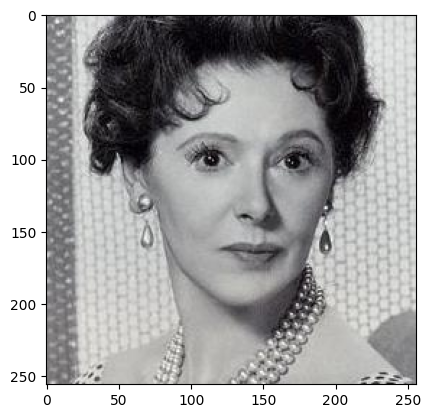

In [44]:
f_name = Path(input_pose_mirrored_folder) / sample_file
img_orig = cv2.imread(str(f_name), 1)
plt.imshow(img_orig[:, :, ::-1])
plt.show()

k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
img = cv2.resize(img_orig, None, fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)

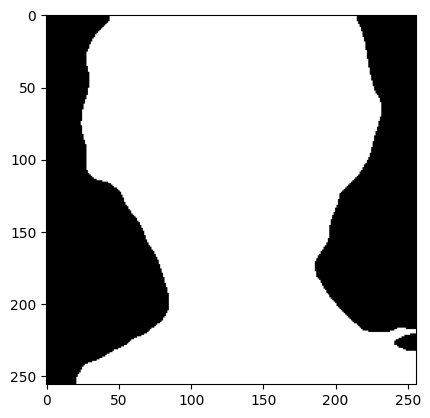

In [45]:
deeplab_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def apply_deeplab(deeplab, img, device):
    input_tensor = deeplab_preprocess(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_batch.to(device))['out'][0]
    output_predictions = output.argmax(0).cpu().numpy()
    return (output_predictions == 15)

mask = apply_deeplab(deeplab, img, device)

plt.imshow(mask, cmap="gray")
plt.show()

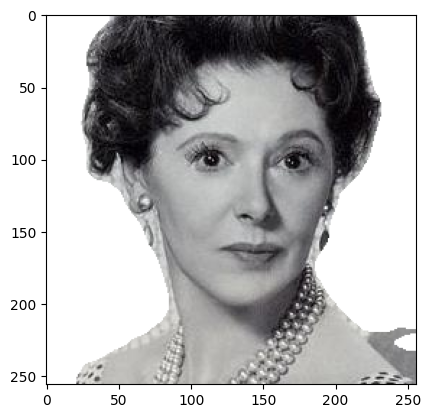

In [46]:
# apply mask to original image
img_masked = img_orig.copy()
img_masked[~mask] = 255
plt.imshow(img_masked[:, :, ::-1])
plt.show()

# Apply mask to original image

In [55]:
Path(output_pose_cut_folder).mkdir(parents=True, exist_ok=True)

In [56]:
for f_name, record in tqdm(records.items()):
    img_orig = cv2.imread(str(Path(input_pose_mirrored_folder) / f_name), 1)
    k = min(1.0, 1024/max(img_orig.shape[0], img_orig.shape[1]))
    img = cv2.resize(img_orig, None, fx=k, fy=k, interpolation=cv2.INTER_LANCZOS4)
    mask = apply_deeplab(deeplab, img, device)
    img_masked = img_orig.copy()

    cv2.imwrite(str(Path(output_pose_cut_folder) / (f_name.replace('.jpg', '') + '_mask.jpg')), mask.astype(np.uint8) * 255)
    
    img_masked[~mask] = 255
    cv2.imwrite(str(Path(output_pose_cut_folder) / f_name), img_masked)

  1%|▏         | 219/15351 [02:56<3:23:01,  1.24it/s]

KeyboardInterrupt

